<a href="https://colab.research.google.com/github/cyamize/kaggle_training/blob/main/Predict_Future_Sales%EC%BA%90%EA%B8%80%ED%94%84%EB%A1%9C%EC%9E%AD%ED%8A%B8_%EC%A0%95%EC%9E%AC%ED%99%98_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score,  train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns



In [ ]:
df_item_categories = pd.read_csv('C:\Kaggle\item_categories.csv')
df_items = pd.read_csv('C:\Kaggle\items.csv')
df_sales_train = pd.read_csv('C:\Kaggle\sales_train.csv')
df_sample_submission = pd.read_csv('C:\Kaggle\sample_submission.csv')
df_shops = pd.read_csv('C:\Kaggle\shops.csv')
df_test  = pd.read_csv('C:/Kaggle/test.csv')


각 파일의 컬럼들과 성분 확인

In [ ]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
df_shops.tail()

,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


In [ ]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [ ]:
df_test.tail()

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [ ]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
df_sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [ ]:
df_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


df_sales_train()의 date가 object이므로  정수화시킨다

In [ ]:
df_date_sales = pd.to_datetime(df_sales_train['date'], dayfirst=True)

In [ ]:
df_date_sales

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

In [ ]:
df_date_sales = df_date_sales.rename('date_sail')

In [ ]:
df_date_sales

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date_sail, Length: 2935849, dtype: datetime64[ns]

In [ ]:
df_train = pd.concat([df_sales_train, df_date_sales], axis=1)
df_train.head()
df_train.drop(['date'],axis=1)


,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sail
0,0,59,22154,999.00,1.0,2013-01-02
1,0,25,2552,899.00,1.0,2013-01-03
2,0,25,2552,899.00,-1.0,2013-01-05
3,0,25,2554,1709.05,1.0,2013-01-06
4,0,25,2555,1099.00,1.0,2013-01-15
...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015-10-10
2935845,33,25,7460,299.00,1.0,2015-10-09
2935846,33,25,7459,349.00,1.0,2015-10-14
2935847,33,25,7440,299.00,1.0,2015-10-22


date_sail로 만든항목을 보기 편하게 month와 year로 분할 및 date 삭제

In [ ]:
df_train['month'] = df_train['date_sail'].dt.month
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sail,month
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02,1
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03,1
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05,1
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06,1
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15,1
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,2015-10-10,10
2935845,09.10.2015,33,25,7460,299.00,1.0,2015-10-09,10
2935846,14.10.2015,33,25,7459,349.00,1.0,2015-10-14,10
2935847,22.10.2015,33,25,7440,299.00,1.0,2015-10-22,10


In [ ]:
df_train.drop(['date'], axis=1, inplace = True)

In [ ]:
df_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sail,month
0,0,59,22154,999.00,1.0,2013-01-02,1
1,0,25,2552,899.00,1.0,2013-01-03,1
2,0,25,2552,899.00,-1.0,2013-01-05,1
3,0,25,2554,1709.05,1.0,2013-01-06,1
4,0,25,2555,1099.00,1.0,2013-01-15,1
...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015-10-10,10
2935845,33,25,7460,299.00,1.0,2015-10-09,10
2935846,33,25,7459,349.00,1.0,2015-10-14,10
2935847,33,25,7440,299.00,1.0,2015-10-22,10


In [ ]:
df_train['year'] = df_train['date_sail'].dt.year
df_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sail,month,year
0,0,59,22154,999.00,1.0,2013-01-02,1,2013
1,0,25,2552,899.00,1.0,2013-01-03,1,2013
2,0,25,2552,899.00,-1.0,2013-01-05,1,2013
3,0,25,2554,1709.05,1.0,2013-01-06,1,2013
4,0,25,2555,1099.00,1.0,2013-01-15,1,2013
...,...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015-10-10,10,2015
2935845,33,25,7460,299.00,1.0,2015-10-09,10,2015
2935846,33,25,7459,349.00,1.0,2015-10-14,10,2015
2935847,33,25,7440,299.00,1.0,2015-10-22,10,2015


In [ ]:
df_train.drop(['date_sail'], axis=1, inplace = True)
df_train

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,0,59,22154,999.00,1.0,1,2013
1,0,25,2552,899.00,1.0,1,2013
2,0,25,2552,899.00,-1.0,1,2013
3,0,25,2554,1709.05,1.0,1,2013
4,0,25,2555,1099.00,1.0,1,2013
...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,10,2015
2935845,33,25,7460,299.00,1.0,10,2015
2935846,33,25,7459,349.00,1.0,10,2015
2935847,33,25,7440,299.00,1.0,10,2015


groupby를 통해 iten_cnt_day의 합계를 구한다

In [ ]:
train = df_train.groupby(['shop_id', 'item_id','month','year'])['item_cnt_day'].sum()

In [ ]:
train

shop_id  item_id  month  year
0        30       2      2013    31.0
         31       2      2013    11.0
         32       1      2013     6.0
                  2      2013    10.0
         33       1      2013     3.0
                                 ... 
59       22164    4      2015     2.0
                  7      2015     1.0
         22167    6      2014     1.0
                  10     2013     1.0
                  12     2013     2.0
Name: item_cnt_day, Length: 1609124, dtype: float64

In [ ]:
train = train.reset_index() # index를 처음부터 다시 정렬
train

,shop_id,item_id,month,year,item_cnt_day
0,0,30,2,2013,31.0
1,0,31,2,2013,11.0
2,0,32,1,2013,6.0
3,0,32,2,2013,10.0
4,0,33,1,2013,3.0
...,...,...,...,...,...
1609119,59,22164,4,2015,2.0
1609120,59,22164,7,2015,1.0
1609121,59,22167,6,2014,1.0
1609122,59,22167,10,2013,1.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   shop_id       1609124 non-null  int64  
 1   item_id       1609124 non-null  int64  
 2   month         1609124 non-null  int64  
 3   year          1609124 non-null  int64  
 4   item_cnt_day  1609124 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 61.4 MB


In [ ]:
train.describe()

,shop_id,item_id,month,year,item_cnt_day
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,6.154612e+00,2.013793e+03,2.267200e+00
std,1.653701e+01,6.238883e+03,3.455231e+00,7.773326e-01,8.649882e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,-2.200000e+01
25%,2.100000e+01,5.045000e+03,3.000000e+00,2.013000e+03,1.000000e+00
50%,3.100000e+01,1.049700e+04,6.000000e+00,2.014000e+03,1.000000e+00
75%,4.700000e+01,1.606000e+04,9.000000e+00,2.014000e+03,2.000000e+00
max,5.900000e+01,2.216900e+04,1.200000e+01,2.015000e+03,2.253000e+03


In [ ]:
# 실제 목표값이 [0,20]범위로 잘려야 한다 하였다
# 그러므로 item_cnt_day 값이 최대 20을 넘지 않고, 최소값이 0이도록 lambda함수 사용
train['item_cnt_day'] = train['item_cnt_day'].map(lambda x: max(0, min(20,x)))

In [ ]:
train

,shop_id,item_id,month,year,item_cnt_day
0,0,30,2,2013,20.0
1,0,31,2,2013,11.0
2,0,32,1,2013,6.0
3,0,32,2,2013,10.0
4,0,33,1,2013,3.0
...,...,...,...,...,...
1609119,59,22164,4,2015,2.0
1609120,59,22164,7,2015,1.0
1609121,59,22167,6,2014,1.0
1609122,59,22167,10,2013,1.0


In [ ]:
train.describe()

,shop_id,item_id,month,year,item_cnt_day
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,3.280585e+01,1.068099e+04,6.154612e+00,2.013793e+03,2.022806e+00
std,1.653701e+01,6.238883e+03,3.455231e+00,7.773326e-01,2.577964e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00
25%,2.100000e+01,5.045000e+03,3.000000e+00,2.013000e+03,1.000000e+00
50%,3.100000e+01,1.049700e+04,6.000000e+00,2.014000e+03,1.000000e+00
75%,4.700000e+01,1.606000e+04,9.000000e+00,2.014000e+03,2.000000e+00
max,5.900000e+01,2.216900e+04,1.200000e+01,2.015000e+03,2.000000e+01


In [ ]:
train

,shop_id,item_id,month,year,item_cnt_day
0,0,30,2,2013,20.0
1,0,31,2,2013,11.0
2,0,32,1,2013,6.0
3,0,32,2,2013,10.0
4,0,33,1,2013,3.0
...,...,...,...,...,...
1609119,59,22164,4,2015,2.0
1609120,59,22164,7,2015,1.0
1609121,59,22167,6,2014,1.0
1609122,59,22167,10,2013,1.0


In [ ]:
# 타겟데이터에 해당하는 item_cnt_day 칼럼을 y에 넣고, train에서는 삭제한다
y = train['item_cnt_day']

In [ ]:
del train['item_cnt_day']
train

,shop_id,item_id,month,year
0,0,30,2,2013
1,0,31,2,2013
2,0,32,1,2013
3,0,32,2,2013
4,0,33,1,2013
...,...,...,...,...
1609119,59,22164,4,2015
1609120,59,22164,7,2015
1609121,59,22167,6,2014
1609122,59,22167,10,2013


test 파일 항목확인 및 정리

In [ ]:
df_test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
test = df_test.drop(['ID'], axis=1)
test

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [ ]:
# test에 null값이 있는지 확인
test.isnull().sum()

shop_id    0
item_id    0
dtype: int64

In [ ]:
# 타겟데이터 y 확인
y

0          20.0
1          11.0
2           6.0
3          10.0
4           3.0
           ... 
1609119     2.0
1609120     1.0
1609121     1.0
1609122     1.0
1609123     2.0
Name: item_cnt_day, Length: 1609124, dtype: float64

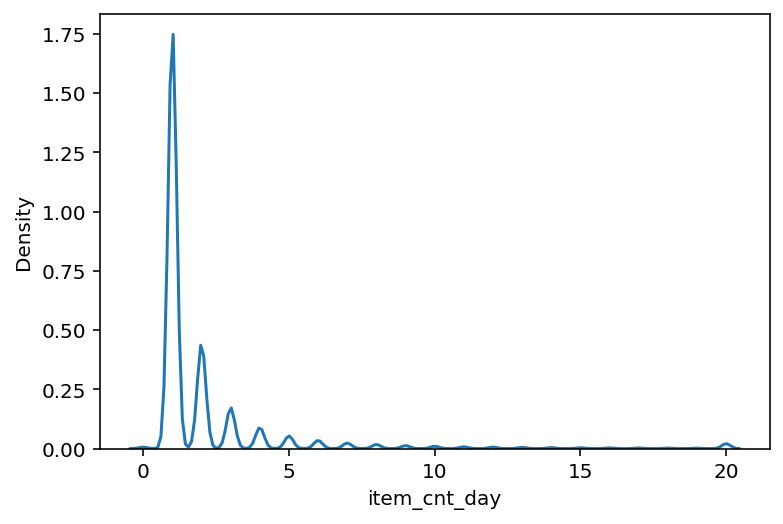

In [ ]:
# 판매데이터 분포 확인
sns.kdeplot(y)
plt.show()

In [ ]:
# 왼쪽으로 크게 치우쳐져 있으므로 y를 np.log1p()함수를 통해 로그변환을 해주고
# 나중에 np.exp1m()로 되돌린다.

y = np.log1p(y)
y

0          3.044522
1          2.484907
2          1.945910
3          2.397895
4          1.386294
             ...   
1609119    1.098612
1609120    0.693147
1609121    0.693147
1609122    0.693147
1609123    1.098612
Name: item_cnt_day, Length: 1609124, dtype: float64

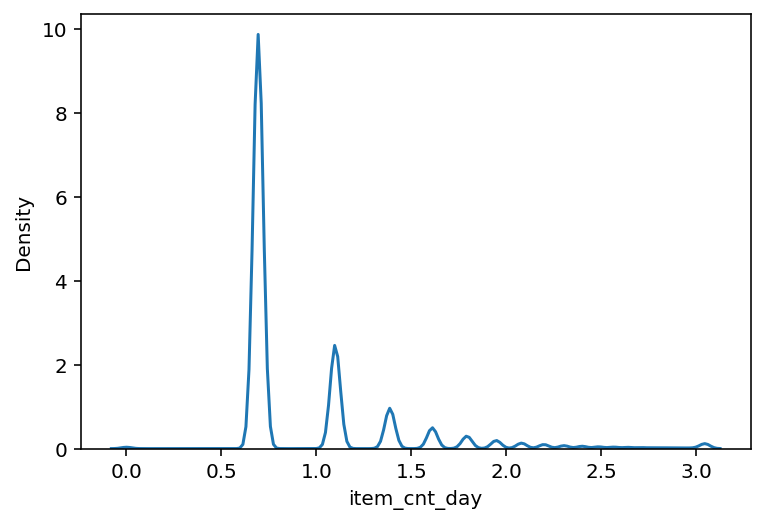

In [ ]:
sns.kdeplot(y)
plt.show()

In [ ]:
# info()함수를 통해 전체 데이터 자료형을 확인한다
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   shop_id  1609124 non-null  int64
 1   item_id  1609124 non-null  int64
 2   month    1609124 non-null  int64
 3   year     1609124 non-null  int64
dtypes: int64(4)
memory usage: 49.1 MB


## RMSE 계산

In [ ]:
test

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   shop_id  214200 non-null  int64
 1   item_id  214200 non-null  int64
dtypes: int64(2)
memory usage: 3.3 MB


rmse 계산을 위한 함수정의

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

4가지 model을 가져온다

In [ ]:
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state 로 고정값을 주어 머신러닝 학습결과를 고정 시킨다.

In [ ]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


네 가지 모델에 대한 RMSE값을 얻는다.

In [ ]:
df = {}
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__
    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    # 모델 학습
    model.fit(X_train, y_train)
    # 예측
    y_pred = model.predict(X_test)
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
df



{'GradientBoostingRegressor': 2.533238168991933,
 'XGBRegressor': 2.226428751647576,
 'LGBMRegressor': 2.4840282965504255,
 'RandomForestRegressor': 1.7489405860712433}

RndomForest가 가장 좋은값을 낸다는 것을 알 수 있다.

위의 과정을 get_scores(models, train, y)함수로 만들었다

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        model.fit(X_train, y_train)
   
        y_pred = model.predict(X_test)
  
        df[model_name] = rmse(y_test, y_pred)
   
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

다양한 파라미터로 실험

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid에 탐색할 xgboost관련 하이퍼 파라미터를 넣어서 준비한다.

In [ ]:
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [1,10],
}


In [ ]:
model = RandomForestRegressor(random_state=random_state)

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  7.4min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([ 16.39293537,  36.80972257, 122.73987255, 254.63810163]),
 'std_fit_time': array([0.2088554 , 0.34710642, 3.86233095, 5.719335  ]),
 'mean_score_time': array([0.38343282, 0.7419538 , 1.10913382, 1.71881642]),
 'std_score_time': array([0.02140655, 0.05638901, 0.04913703, 0.29455519]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.18430918, -0.18431181, -0.16873046, -0.16797055]),
 'split1_test_score': array([-0.22920756, -0.22920624, -0.20926514, -0.2087725 ]),
 'split2_test_score': array([-0.

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.21165765, -0.21165806, -0.1956812 , -0.19549574])

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
results = pd. DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.211658
1,1,100,-0.211658
2,10,50,-0.195681
3,10,100,-0.195496


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.211658,0.460063
1,1,100,-0.211658,0.460063
2,10,50,-0.195681,0.442359
3,10,100,-0.195496,0.442149


In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.211658,0.460063
1,1,100,-0.211658,0.460063
2,10,50,-0.195681,0.442359
3,10,100,-0.195496,0.442149


In [ ]:
results = results.sort_values('RMSLE')
results


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.195496,0.442149
2,10,50,-0.195681,0.442359
0,1,50,-0.211658,0.460063
1,1,100,-0.211658,0.460063


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)
    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    # RMSE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results


In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}
model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  7.2min finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.195496,0.442149
2,10,50,-0.195681,0.442359
0,1,50,-0.211658,0.460063
1,1,100,-0.211658,0.460063


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609124 entries, 0 to 1609123
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   shop_id  1609124 non-null  int64
 1   item_id  1609124 non-null  int64
 2   month    1609124 non-null  int64
 3   year     1609124 non-null  int64
dtypes: int64(4)
memory usage: 49.1 MB


In [ ]:
y

0          3.044522
1          2.484907
2          1.945910
3          2.397895
4          1.386294
             ...   
1609119    1.098612
1609120    0.693147
1609121    0.693147
1609122    0.693147
1609123    1.098612
Name: item_cnt_day, Length: 1609124, dtype: float64

In [ ]:
del train['month']

In [ ]:
del train['year']

In [ ]:
model = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([0.99428916, 0.99428916, 0.99428916, ..., 0.86673055, 0.81895747,
       0.83524015])

In [ ]:

submission_path = join('C:\Kaggle\sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.903556
1,1,0.963989
2,2,0.921971
3,3,0.921971
4,4,0.990729


In [ ]:
submission['item_cnt_month'] = prediction
submission.head()

,ID,item_cnt_month
0,0,0.994289
1,1,0.994289
2,2,0.994289
3,3,0.994289
4,4,0.994289


In [ ]:
submission

,ID,item_cnt_month
0,0,0.994289
1,1,0.994289
2,2,0.994289
3,3,0.994289
4,4,0.994289
...,...,...
214195,214195,0.836205
214196,214196,0.866731
214197,214197,0.866731
214198,214198,0.818957


In [ ]:
submission_csv_path = join('C:\Kaggle\sample_submission.csv')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


C:\Kaggle\sample_submission.csv
